### Segmentation according to the peaks of PPG

In [32]:
import scipy.io
import matplotlib.pyplot as plt

def segmentation(data_part, rid=1, winLenInSec_=2, srate=125, newSrate=125, normFlag=True):
    """
    Perform segmentation for a given recording designated by PID and RID
    @Parameters:
    data_part: dictionary, loaded data part by function load_data_part
    rid: integer, RID, Recording ID, under associated PID.
    winLenInSec: integer, window length that used for the segementation. The unit is second.
    srate: integer, sampling rate of the loaded signal
    newSrate: integer, required sampling rate after down sampling. If no down sampling is required, newSrate = srate.
    normFlag: boolean, request normalization or not.
    @Return:
    X: array, shape(num_sample, num_winLenInPnt), segmented PPG signal
    Y: array, shape(num_sample, num_winLenInPnt), segmented ABP signal
    """
    
    return

In [23]:
import scipy.io
pid = 1
data_part = load_data_part(pid)  

pid, rid, winLenInSec, srate, newSrate, normFlag = data_part, 1, 2, 125, 125, True
  

> Loading data part_1...

> Data part_1 loaded. 



In [28]:
winLen = winLenInSec * newSrate
data_raw = data_part['p'][0][rid]
PPG = data_raw[0]
ABP = data_raw[1]


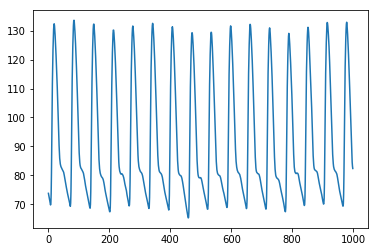

In [34]:
plt.plot(ABP[:1000])
plt.show()

In [22]:
# Load Part with ID
def load_data_part(pid = 1):
    print ('> Loading data part_' + str(pid) + '...\n')
    data_part = scipy.io.loadmat('../database/KData/BloodPressureDataset/part_' + str(pid) + '.mat')
    print ('> Data part_' + str(pid) + ' loaded. \n')
    return data_part

# normalization
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / np.mean(window)) - 1) for p in window]
        normalised_data.append(normalised_window)
    normalised_data = np.array(normalised_data)
    return normalised_data